# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1 Generate our dataset

### 1.1 Define the data generating processes 

In [2]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([], []),
    ArmaProcess.from_coeffs([-0.5], []),
    ArmaProcess.from_coeffs([], [0.9]),
    ArmaProcess.from_coeffs([0.5], [0.5])
]

### 1.2 Generate samples from each process 

In [3]:
# Number of time series per process
series_per_process = 3

# Length of an individual time series
T = 1_000

n_processes = len(processes)
n_series = n_processes * series_per_process

# Generate the time series.
df = pd.DataFrame()
for i in range(n_series):
    df[f"TS_{i}"] = processes[i // series_per_process].generate_sample(T)

In [4]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,-1.635085,0.134038,-0.188085,-1.786215,-0.985281,-0.180337,-0.192613,-0.531775,-0.298865,-0.365558,-0.553783,0.884580
1,-0.720275,-1.950197,-0.482394,2.360701,1.450489,0.191358,-0.582244,-0.794101,-1.520127,0.975538,0.270219,-0.019364
2,0.004042,0.776214,0.376333,-1.965323,0.638855,0.710330,-0.085781,-1.472410,-1.365689,0.627627,0.650476,1.179028
3,-2.014638,-1.284443,0.197122,2.211283,0.431318,-0.208734,-0.240615,-0.521566,1.243498,0.464499,-0.236229,0.070766
4,0.105753,-1.225073,-0.974953,-0.810684,-1.193628,-1.143217,-0.336858,-1.436099,1.657494,-1.844225,-0.900511,0.857382
5,0.468386,1.190902,-0.143647,-0.001982,0.631036,1.241287,-0.261559,-2.061148,1.774210,0.010279,0.646394,1.055123
6,0.924607,0.343310,0.558401,1.903257,-1.144255,-1.098479,1.367681,0.776464,0.813409,0.858910,1.242474,0.426284
7,-0.622202,-0.084269,1.987895,-1.707197,1.575077,0.849893,1.729005,1.659216,0.899069,0.080754,0.028188,0.899652
8,0.197530,0.267082,0.417096,0.580482,-1.302280,-0.505855,0.824509,0.380503,0.616437,0.379029,0.322892,-0.199034
9,1.130382,-0.519204,2.078906,-1.027626,0.525603,-0.135983,0.171473,-0.179130,1.043836,-0.574108,0.362030,-1.641029


In [5]:
def plot_df(df, lower, upper, process):
    n_rows = upper - lower
    fig, ax = plt.subplots(
        nrows=n_rows, ncols=1,
        sharex=True, sharey=False,
        figsize=(12, 2 * n_rows),
        tight_layout=True)
    fig.suptitle(f"TS {lower}-{upper-1}\n{process}")
    for i in range(n_rows):
        ts_idx = lower + i
        ax[i].plot(df.iloc[:, ts_idx])
        #ax[i].set_title(f"TS {ts_idx}")
    plt.show()

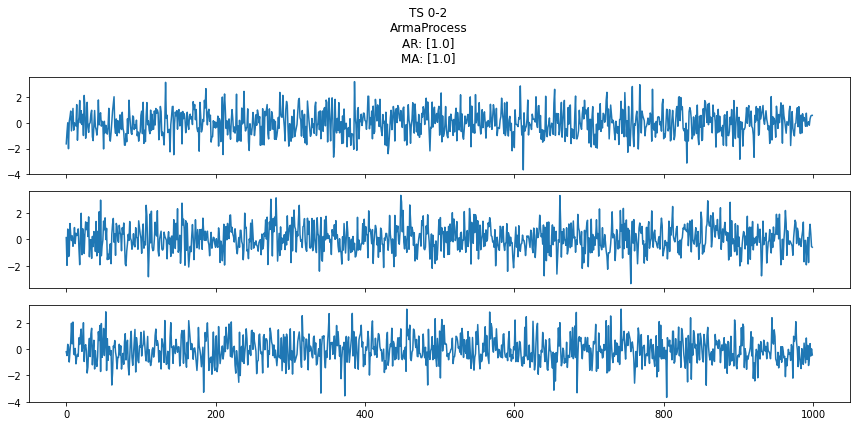

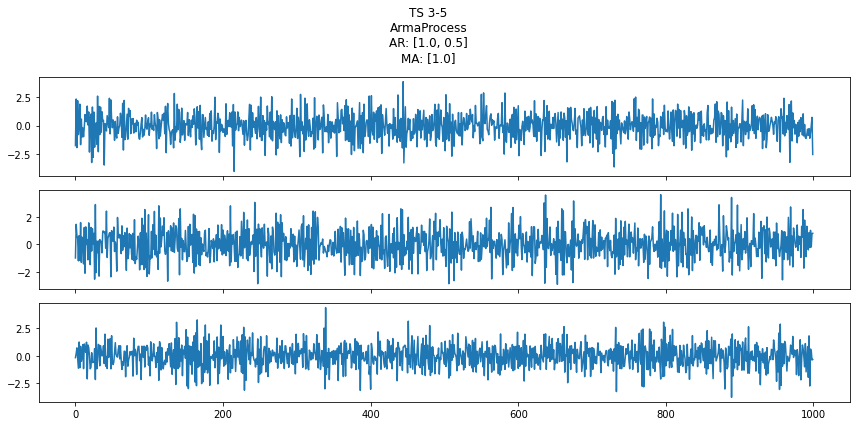

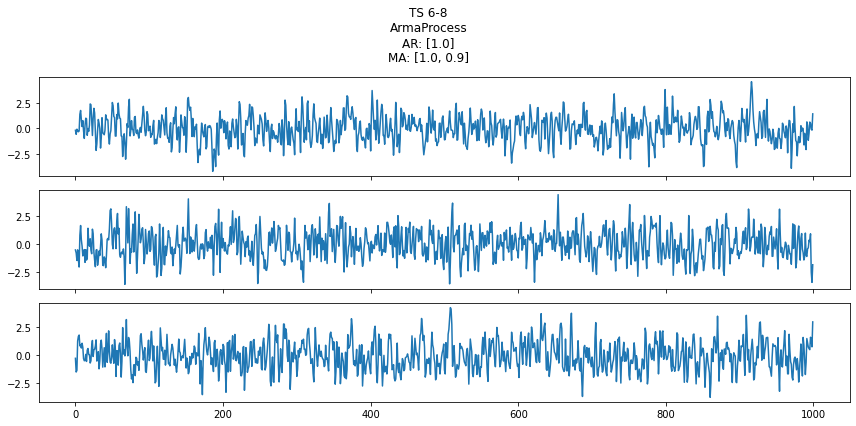

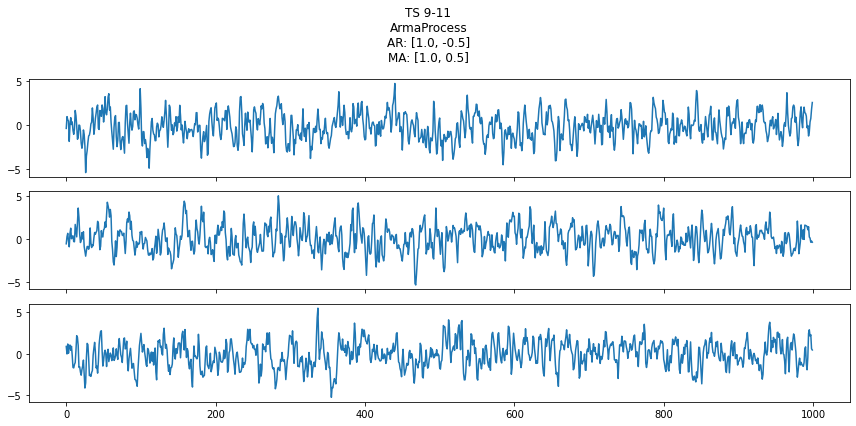

In [6]:
for i in range(n_processes):
    lower = i * series_per_process
    upper = lower + series_per_process
    plot_df(df, lower, upper, processes[i])

## 2 Estimate ACFs 

In [7]:
def acf(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

# Max ACF lags
n_lags = 20

lag_arr = np.repeat(n_lags, df.shape[1])
acf_list = list(map(acf, df.transpose().to_numpy(), lag_arr))
acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns

In [8]:
acf_df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.021742,0.022795,0.018455,-0.479560,-0.507172,-0.512885,0.523172,0.431137,0.487205,0.700163,0.730868,0.728470
2,-0.025306,0.074974,0.001974,0.185309,0.288859,0.269620,0.050968,-0.082342,0.005735,0.333120,0.377684,0.396034
3,0.039106,-0.012897,0.018797,-0.052182,-0.139802,-0.159387,0.044964,-0.020798,0.028725,0.159815,0.175099,0.230821
4,-0.020384,-0.017758,-0.048598,0.031328,0.080389,0.079322,0.045968,0.018077,0.030575,0.073435,0.072447,0.152638
5,0.033361,-0.008830,-0.043481,0.004974,-0.000634,-0.026972,0.011364,0.055051,-0.009323,0.061008,0.033170,0.118277
6,-0.034760,-0.012765,-0.032470,-0.013063,-0.002377,0.003611,-0.031205,0.017881,-0.057936,0.081589,0.010032,0.094846
7,-0.013474,0.032370,-0.011027,0.011246,-0.002235,-0.005576,-0.008470,-0.047303,-0.047535,0.072427,-0.005048,0.092187
8,-0.036502,0.027192,0.013399,-0.038931,0.006114,-0.025764,0.026758,-0.032482,-0.034222,0.047508,-0.038640,0.065412
9,-0.031642,-0.017453,0.017345,-0.018389,-0.024082,0.023307,-0.016164,0.013102,-0.051758,0.015576,-0.073738,0.007032


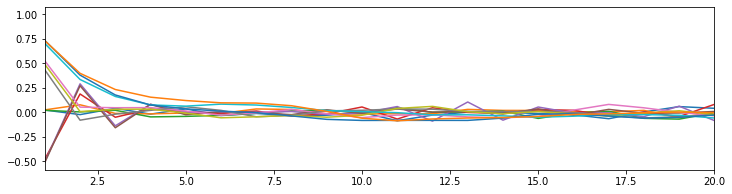

In [9]:
plt.figure(figsize=(12, 3))
plt.xlim((1, n_lags))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [10]:
n_clusters = n_processes
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([2, 2, 2, 0, 0, 0, 3, 3, 3, 1, 1, 1], dtype=int32)

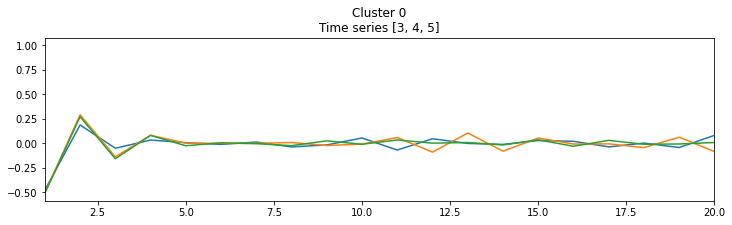

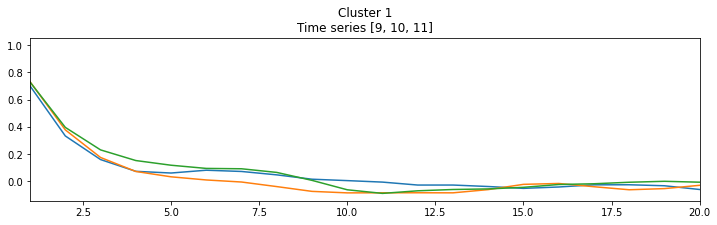

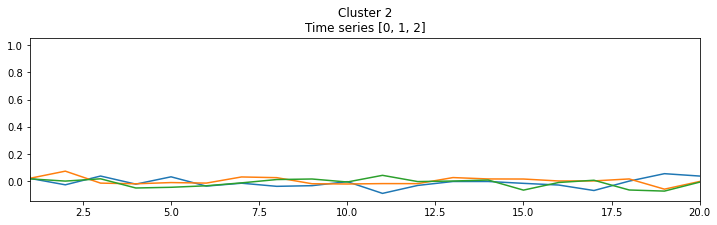

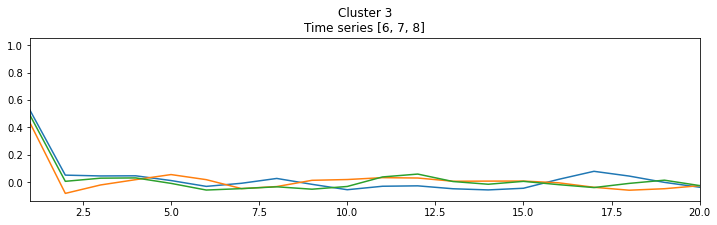

In [11]:
# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    ts = []

    # j ranges over the series ACFs
    for j in range(n_series):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
    
    plt.title(f"Cluster {i}\nTime series {ts}")
    plt.show()